# <span style="color:red">***OBSOLETE***</span>

<span style="color:red">The content in this jupyter notebook is obsolete, please refer to <code>http://yenhsunlin.github.io/snorer</code> for documentation.</span>

# Tutorial for `snorer`


In this tutorial, I'll briefly go through main classes and functions that are used to evaluate the time-of-flight signature carried by supernova-neutrino-boosted dark matter (SN$\nu$ BDM) due to SN in our Milky Way (MW), Large Magellanic Cloud (LMC) or any in the distant galaxy.


We begin with importing `snorer` and other useful packages in this tutorial. Note that `multiprocessing` is not compatible with jupyter on Mac/Windows systems.
One can alternatively use `ipyparallel` to manifest multiprocessing feature on jupyter. This task is relegated to the reader.

In [1]:
# import complete modules from packages
import multiprocessing as mp
import numpy as np

import snorer
print(f'Current version of snorer: {snorer.__version__}')

import matplotlib.pyplot as plt

# import only necessary modules from packages
from functools import partial

# uncomment this if you have a Hi-DPI monitor and wish to have a better figure resolution
#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Current version of snorer: 1.0.0


## 1 The Useful Constants

We introduce the instance `constant` which contains various useful attributes that are frequently used.
For example the electron mass $m_e$ in MeV can be retrieved by

In [2]:
snorer.constant.me

0.511

**- Attributes -**

- *attribute* **perMeV2cm** : Convert MeV<sup>−1</sup> to cm
- *attribute* **year2Seconds** : Convert 1 year to seconds
- *attribute* **erg2MeV** : Convert 1 erg to MeV
- *attribute* **kpc2cm** : Convert 1 kpc to cm
- *attribute* **me** : Electron mass, MeV
- *attribute* **mn** : Neutron mass, MeV
- *attribute* **mp** : Proton mass, MeV
- *attribute* **Msun** : Solar mass $M_\odot$, MeV
- *attribute* **Msun_kg** : Solar mass $M_\odot$, kg
- *attribute* **Mmw** : MW stellar mass, $M_\odot$
- *attribute* **M_SgrA** : The supermassive black hole (SMBH) mass of Sagittarius A*, $M_\odot$
- *attribute* **Mhalo** : MW DM halo mass, $M_\odot$
- *attribute* **c** : Speed of light, cm s<sup>−1</sup>
- *attribute* **H0** : Hubble constant, km s<sup>−1</sup> Mpc<sup>−1</sup>
- *attribute* **G** : Gravitational constant, ${\rm pc}~M_\odot^{-1}~{\rm (km/s)^2}$
- *attribute* **SgrA_coord** : Sagittarius A* coordinate in ICRS J2000.0 including distance in kpc, [RA,DEC,$R_{\rm star}$], list
- *attribute* **LMC_coord** : LMC coordinate in ICRS J2000.0 including distance in kpc, [RA,DEC,$R_{\rm star}$], list
- *attribute* **SN1987a_coord** : SN1987a coordinate in ICRS J2000.0 including distance in kpc, [RA,DEC,$R_{\rm star}$], list

In the above, RA means the right ascension and DEC the declination.

## 2 The SN$\nu$ Spectrum

The total SN$\nu$ flux, including three flavors and anit-species, is given by
$$
\frac{d\phi_\nu}{dE_\nu}=\sum_{i}\frac{L_{\nu_{i}}}{4\pi \ell^{2}\langle E_{\nu_{i}}\rangle}E_{\nu}^{2}f_{\nu_{i}}(E_{\nu})
$$
where $f_\nu (E_\nu)$ is the Fermi-Dirac distribution for neutrinos and $i=e,\mu,\tau$ the (anti-)neutrino flavors.
The SN$\nu$ number density within the shell can be associated with its flux divided by velocity
$$
\frac{dn_\nu}{dE_\nu} = \frac{1}{v}\frac{d\phi_\nu}{dE_\nu}=\frac{d\phi_\nu}{c dE_\nu}
$$
where we assumed neutrino is massless and $v=c$.

### 2.a The Useful Functions

#### snorer.snNuSpectrum

`snorer.snNuSpectrum(Ev,D,D_trunct=3.24e-15,is_density=False)` Obtain the SN$\nu$ spctrum after propagating a distance $D$

##### Parameters:

   - **Ev** : Neutrino energy $E_\nu$ in MeV, float
   - **D** : Distance $D$ from the boosted point to the SN in kpc, float
   - **D_trucnt** : Truncation point for $D$ to prevent divergence when $D<D_{\rm trunc}$ in kpc, float
   - **is_density** : Should the output be flux or number density, bool


##### Returns:

   - **Spectrum** : Flux (MeV<sup>−1</sup> cm<sup>−2</sup> s<sup>−1</sup>) or
                number density (MeV<sup>−1</sup> cm<sup>−3</sup>)
### 2.b Examples

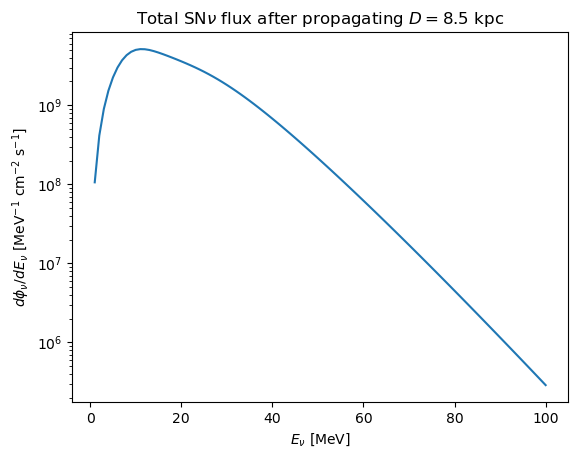

In [3]:
# SNv flux that is 8.5 kpc distant away from the explosion site
D = 8.5
EvList = np.linspace(1,100,100)
SNv_flux = [snorer.snNuSpectrum(Ev,D) for Ev in EvList]  # sigv has no effect whatever value you set 

#　Make the plot
plt.plot(EvList,SNv_flux)
plt.yscale('log')
plt.title(r'Total SN$\nu$ flux after propagating $D=8.5$ kpc')
plt.xlabel(r'$E_\nu$ [MeV]')
plt.ylabel(r'$d\phi_\nu/dE_\nu$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.show()

## 3 The DM Halo Profile

We parametrize the DM halo density profile by
$$
    \rho_\chi(r)=\frac{\rho_s}{\frac{r}{r_s}(1+ \frac{r}{r_s})^n}
$$
where $\rho_s$, $r_s$ and $n$ are the characteristic density, radius and slope of the profile. For number density, it can be obetained by
$$
n_\chi(r,m_\chi) = \frac{\rho_\chi(r)}{m_\chi}.
$$
Furthermore, as suggested in *Phys. Rev. Lett.* **83**, 1719 (1999), DM can form a spike due to SMBH's gravitational pull in the galactic center.
We follow the parametrization for DM profile with spike in the inner galactic region in *JCAP* **06**, 004 (2023) to construct this phenomenon.



### 3.a  The Useful Functions

#### snorer.rhox
`snorer.rhox(r,/,rhos,rs,n)` Obtain DM halo denisty $\rho_\chi$ at $r$

##### Parameters:

   - **r** : The distance $r$ to GC in kpc, float
   - **rhos** : The characteristic density $\rho_s$ in MeV cm<sup>−3</sup>, float
   - **rs** : The characteristic radius $r_s$ in kpc, float
   - **n** : The slope $n$ of the profile, float


##### Returns:

   - $\rho_\chi(r)$ : DM halo density in MeV cm<sup>−3</sup>, float

#### snorer.dmNumberDensity

`snorer.dmNumberDensity(r,mx,/,is_spike=True,sigv=None,tBH=1e10,profile='MW',alpha='3/2',**kwargs)` Obtain $n_\chi$ at $r$ for a given $m_\chi$

##### Parameters:
   
   - **r** : The distance $r$ to GC in kpc, float
   - **mx** : The DM mass $m_\chi$ in MeV, float
   - **is_spike** : Turn/off spike feature, bool
   - **sigv** : DM annihilation cross section $\langle\sigma v\rangle$ in the unit of $3\times 10^{-26}~{\rm cm^3~s^{-1}}$, float or **None** indicating no annihilation
   - **tBH** : Age of the SMBH $t_{\rm BH}$, years
   - **profile** : Which galaxy user's looking into, string, **'MW'** or **'LMC'**
   - **alpha** : Slope $\alpha$ of the spike profile, string, **'3/2'** or **'7/3'**
   - **\*\*kwargs** : Keyword arguments that will be passed to the class `HaloSpike`

##### Returns:

   - $n_\chi(r)$ :  DM halo number density in cm<sup>−3</sup>, float

### 3.b Examples

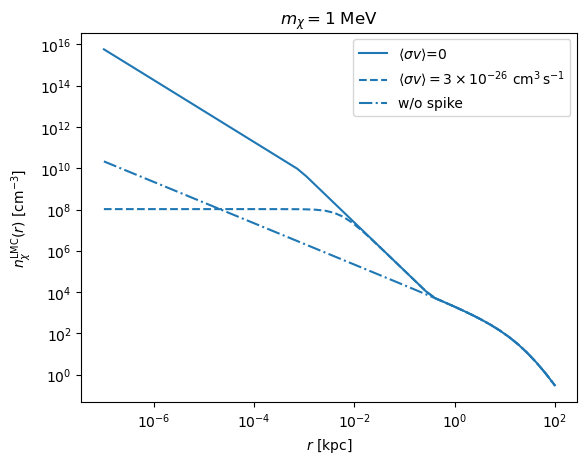

In [4]:
# Display the LMC DM halo number density 
mx = 1
rList = np.logspace(-7,2,50)
nxLMC_sigv0 = [snorer.dmNumberDensity(r,mx,profile='LMC') for r in rList]
nxLMC_sigv3 = [snorer.dmNumberDensity(r,mx,sigv=3,profile='LMC') for r in rList]
nxLMC_nospike = [snorer.dmNumberDensity(r,mx,is_spike=False,profile='LMC') for r in rList]  # sigv has no effect whatever value you set 

#　Make the plot
plt.plot(rList,nxLMC_sigv0,color='C0',label=r'$\langle \sigma v\rangle$=0')
plt.plot(rList,nxLMC_sigv3,'--',color='C0',label=r'$\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3\,s^{-1}}$')
plt.plot(rList,nxLMC_nospike,'-.',color='C0',label='w/o spike')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi^{\rm LMC}(r)~[{\rm cm}^{-3}]$')
plt.show()

### 3.c The Classes

#### snorer.HaloSpike

*class*  `snorer.HaloSpike(mBH,tBH,alpha)`

Class for establishing DM halo number density instance with spike due to SMBH in the galactic center.

##### Parameters:

 - **mBH** : SMBH mass $M_{\rm BH}$, $M_\odot$
 - **tBH** : SMBH age $t_{\rm BH}$, years
 - **alpha** : Slope $\alpha$ of the spike profile

*Callable* `__call__(r,mx,/,sigv,rhos,rs,n)` After an instance of `HaloSpike` class is established, it is callable and returns $n_\chi$ at $r$ with spike feature for a given $m_\chi$

##### Parameters:

 - **r** : The distance $r$ to GC in kpc, float
 - **mx** : DM mass $m_\chi$ in MeV, float
 - **sigv** :  DM annihilation cross section $\langle\sigma v\rangle$ in the unit of $3\times 10^{-26}~{\rm cm^3~s^{-1}}$, float or **None** indicating no annihilation
 - **rhos** : The characteristic density $\rho_s$ in MeV cm<sup>−3</sup>, float
 - **rs** :  The characteristic radius $r_s$ in kpc, float
 - **n** : The slope $n$ of the DM profile, float


##### Returns:

   - $n_\chi(r)$ :  DM halo number density with spike feature for $m_\chi$ in cm<sup>−3</sup>, float

## 4 The BDM Kinematics

Considering, initially, an incident particle 1 with mass $m_1$ scattered with a target, particle 2, at rest with mass $m_2$.
After the collision, particle 2 received kinetic energy $T_2$ and deflected by an angle $\psi$ in the lab frame.
To have this $2\to2$ scattering happened, we need to derive the required $T_1$.
The interaction is depicted in the following figure.

<div style="text-align:center"><img src="22_scattering.png" alt="2 -> 2 scattering" width="50%" height="auto">

Note that the total energies of the two particles are actually
\begin{align*}
E_{1} & =T_{1}+m_{1},\\
E_{2} & =T_{2}+m_{2}.
\end{align*}
This completely represents the BDM kinematics as particle 1 is neutrino and 2 is DM. Instead of approximating $m_1\to 0$, we derive the kinematics retaining nonzero $m_{1,2}$ for general purpose. Once this is done, we can directly apply it to an *ad hoc* $\nu$-DM scattering.

We firstly introduce the relevant *classes* and then the useful *functions*.

### 4.a The Classes

#### snorer.Kinematics

*class*  `snorer.Kinematics(m1,m2,T2,psi)` 

Class that constructs the required kinetic energy $T_1$ of incident particle with mass $m_1$ to boost the target with mass $m_2$ to kinetic energy $T_2$. After the collision, the target is deflected by an angle $\psi$ in the lab frame.

##### Parameters:

 - **m1** : Incident particle mass $m_1$ in MeV, float
 - **m2** : Target mass $m_2$ in MeV, float
 - **T2** : Kinetic energy $T_2$ received by the target in MeV, float
 - **psi** : Lab frame scattering angle $\psi$ in rad ($0\leq \psi\leq \pi$), float

**- Methods -**

*method* `get_T1()` Obtain the required energy $T_1$

##### Returns:

   - $T_1$ : The required kinetic energy $T_1$, MeV, of incident particle, float

*method* `get_dT1()` Obtain the Jacobian $\partial T_1/\partial T_2$ that measures the change rate of $T_1$ according to $T_2$

##### Returns:

   - $\partial T_1/\partial T_2$ : The Jacobian, float

*method* `get_sanity()`  Does particle 1 really can scatter particle 2 to have $(T_\chi,\psi)$ 

##### Returns:

   - bool : **True** means yes and **False** means otherwise. **False** usually means the required $T_1$ is negative, which is clearly insane.

*method* `get_dLips()`  Obtain the Lorentz invariant phase space, $\rm dLips$,
$$
\left. \frac{d\sigma_{\chi\nu}}{d\Omega}\right|_\psi=\frac{1}{2\pi}\frac{du}{d\cos\psi}\frac{d\sigma_{\chi\nu}}{du}={\rm dLips}\times|\mathcal{M}|^2
$$
where $u$ is one of the Mandelstam variables and $|\mathcal{M}|^2$ is the square of the scattering amplitude.
This gives you the differential $\nu$-DM cross section at $\psi$ direction, but only works for $|\mathcal{M}|^2$ is known. For model-independent case, we have another easier way to obtain the angular distribution `fx_lab()`.
 
##### Returns:

   - $\rm dLips$ : The Lorentz invariant phase space in ${\rm cm^2~sr^{-1}}$, float

#### snorer.Neutrino

*class*  `snorer.Neutrino(mx,Tx,psi)` 

Bear in mind with the general kinematics of non-zero particles $m_{1,2}$ scattering. We can apply it to a more simple case that has $m_1=m_\nu=0$, $m_2=m_\chi$ and $T_2=T_\chi$.
Under this setup, we will have
\begin{align*}
E_{\nu} & =T_{\nu},\\
E_{\chi} & =T_{\chi}+m_{\chi}.
\end{align*}

##### Parameters:

 - **mx** : DM mass $m_\chi$ in MeV, float
 - **Tx** : DM kinetic energy $T_\chi$ in MeV, float
 - **psi** : DM lab frame scattering angle $\psi$ in rad ($0\leq \psi\leq \pi$), float

##### Attributes:

 - *attribute* **Ev** : The SN$\nu$ energy $E_\nu$ in MeV, float
 - *attribute* **dEv** : The Jacobian $\partial E_\nu/\partial T_\chi$, float
 - *attribute* **is_sanity** : Is this process allowed kinematically, bool

#### snorer.Mandelstam

*class*  `snorer.Mandelstam(m1,m2,T2,psi)` 

Obtain the associated Mandelstam variables $s$, $t$ and $u$

##### Parameters:

 - **m1** : Incident particle mass $m_1$ in MeV, float
 - **m2** : Target mass $m_2$ in MeV, float
 - **T2** : Kinetic energy $T_2$ received by the target in MeV, float
 - **psi** : Lab frame scattering angle $\psi$ in rad ($0\leq \psi\leq \pi$), float

##### Attributes:

 - *attribute* **s** : The Mandelstam variable $s$ in MeV<sup>2</sup>, float
 - *attribute* **t** : The Mandelstam variable $t$ in MeV<sup>2</sup>, float
 - *attribute* **u** : The Mandelstam variable $u$ in MeV<sup>2</sup>, which is derived from $s+t+u=2(m_1^2+m_2^2)$, float
 - *attribute* **T1** : The reguired kinetic energy $T_1$ in MeV, float

### 4.b The Useful Functions

#### snorer.get_vx

`snorer.get_vx(Tx,mx)`  Obtain BDM velocity $v_\chi \in [0,1)$ in the unit of $c$

##### Parameters:

   - **Tx** : The BDM kinetic energy $T_\chi$, float
   - **mx** : The DM mass $m_\chi$ in MeV, float


##### Returns:

   - $v_\chi$ : BDM velocity $v_\chi$ in the unit of $c$, float

#### snorer.fx_lab

`snorer.fx_lab(Ev,mx,psi)`  Obtain the angular distribution of $\nu$-DM cross section at $\psi$
$$
\left.\frac{d\sigma_{\chi\nu}}{d\Omega_{\rm lab}}\right|_\psi = f_\chi(E_\nu,m_\chi,\psi)\times \sigma_{\chi\nu}
$$

##### Parameters:

   - **Ev** : The SN$\nu$ energy $E_\nu$ in MeV, float
   - **mx** : The DM mass $m_\chi$ in MeV, float
   - **psi** : DM lab frame scattering angle $\psi$ in rad ($0\leq \psi\leq \pi$), float 


##### Returns:

   - $f_\chi$ : Angular distribution in ${\rm sr}^{-1}$, float

## 5 The BDM Afterglow and Event Number

### 5.a The BDM Flux and Event

The BDM flux, or so called *afterglow* can be obtained by Eq. (6) in *Phys. Rev. D* **108**, 083013 (2023)
$$
\frac{d\Phi_{\chi}(T_\chi, t^\prime)}{dT_{\chi}dt} =
\left.\tau_s\int_0^{2\pi} d\phi\int_{0}^{\pi/2}\sin\theta d\theta~ \mathcal{J} j_{\chi}(r(\phi),D,T_{\chi},\psi)\right|_{t^{\prime}=\frac{D}{c}+\frac{d}{v_{\chi}}}
$$
where we further define the differential BDM flux
$$
\frac{d\phi_\chi(T_\chi, t^\prime)}{dt dT_\chi d\theta d\phi} \equiv \left. \sin\theta\mathcal{J} j_{\chi}(r(\phi),D,T_{\chi},\psi)\right|_{t^{\prime}=\frac{D}{c}+\frac{d}{v_{\chi}}}
$$

Though the physical range for zenith angle is from $0$ to $2\pi$, the non-zero BDM flux is actually confined within a small range of $\theta$ and can also be determined by `snorer.get_thetaRange()`.
The associated peak time $t_p$ and vanishing time $t_{\rm van}$ can be obtained by `snorer.get_tof()`.

As the flux is known, the corresponding BDM event in a detector with total electron number $N_e$ and DM-$e$ cross section $\sigma_{\chi e}$ is given by
$$
N_{\rm BDM} = N_e\int_{t_{\rm min}}^{t_{\rm exp}} dt \int_{T_{\chi,\rm min}}^{T_{\chi,\rm exp}} dT_\chi \frac{d\Phi_{\chi}(T_\chi, t^\prime)}{dT_{\chi}dt}\sigma_{\chi e}.
$$

### 5.b The Useful Functions

#### snorer.diff_flux

`snorer.diff_flux(t,Tx,mx,theta,phi,Rstar,beta,sigxv0=1e-45,Re=8.5,r_cut=1e-8,tau=10,is_spike=True,sigv=None,tBH=1e10,profile='MW',alpha='3/2',**kwargs)`  Obtain the differential BDM flux $d\phi_\chi/dtdT_\chi d\theta dT_\chi$

##### Parameters:

  - **t** : The BDM arrival time $t$ in seconds, float
  - **Tx** : DM kinetic energy $T_\chi$ in MeV, float
  - **mx** : DM mass $m_\chi$ in MeV, float
  - **theta** : Zenith angle $\theta$ in rad, float
  - **phi** : Azimuthal angle $\phi$ in rad, float
  - **Rstar** : Distance to SN $R_{\rm star}$ in kpc, float
  - **beta** : Off-center angle $\beta$ in rad, float
  - **sigxv0** : DM-$\nu$ scattering cross section $\sigma_{\chi\nu}$ in cm<sup>2</sup>, float
- **Re** : Distance to GC $R_e$ in kpc, float
- **r_cut** : Ignore the BDM contribution when $r < r_{\rm cut}$, float
- **tau** : Duration of SN explosion $\tau$ in seconds, float
- **is_spike** : Turn on/off spike feature, bool
- **sigv** : DM annihilation cross section, in the unit of $10^{-26}~{\rm cm^3~s^{-1}}$, float
- **tBH** : SMBH age $t_{\rm BH}$ in years, float
- **profile** : 'MW' or 'LMC', string
- **alpha** : Slope $\alpha$ of the DM spike, float
- **\*\*kwargs** : See its docstring for detail

##### Returns:

   - diff. flux : MeV<sup>−1</sup> cm<sup>−2</sup> s<sup>−1</sup> sr<sup>−1</sup>

#### snorer.flux

`snorer.flux(t,Tx,mx,Rstar,beta,sigxv0=1e-45,Re=8.5,r_cut=1e-8,tau=10,is_spike=True,sigv=None,tBH=1e10,profile='MW',alpha='3/2',nitn=10,neval=30000,,**kwargs)`  Obtain the BDM flux $d\Phi_\chi/dtdT_\chi$

##### Parameters:

  - **t** : The BDM arrival time in seconds, float
  - **Tx** : DM kinetic energy in MeV, float
  - **mx** : DM mass in MeV, float
  - **Rstar** : Distance to SN in kpc, float
  - **beta** : Off-center angle in rad, float
  - **sigxv0** : DM-$\nu$ scattering cross section in cm<sup>2</sup>, float
- **Re** : Distance to GC in kpc, float
- **r_cut** : Ignore the BDM contribution when $r < r_{\rm cut}$, float
- **tau** : Duration of SN explosion in seconds, float
- **is_spike** : Turn on/off spike feature, bool
- **sigv** : DM annihilation cross section, in the unit of $10^{-26}~{\rm cm^3~s^{-1}}$, float
- **tBH** : SMBH age in years, float
- **profile** : 'MW' or 'LMC', string
- **alpha** : Slope of the DM spike, float
- **nitn** : Number of interation chains in vegas, unsigned int
- **neval** : Number of evaluation number in each chain in vegas, unsigned int
- **\*\*kwargs** : See its docstring for detail

##### Returns:

   - BDM flux : MeV<sup>−1</sup> cm<sup>−2</sup> s<sup>−1</sup>

#### snorer.event

`snorer.event(mx,Rstar,beta,TxRange=[5,30],tRange=[10,35*constant.year2Seconds],sigxv0=1e-45,Re=8.5,r_cut=1e-8,tau=10,is_spike=True,sigv=None,tBH=1e10,profile='MW',alpha='3/2',nitn=10,neval=30000,**kwargs)`  Obtain the BDM event $N_{\rm BDM}$ normalized to $N_e=1$ and $\sigma_{\chi e}=1~{\rm cm^2}$

##### Parameters:

  - **mx** : DM mass in MeV, float
  - **Rstar** : Distance to SN in kpc, float
  - **beta** : Off-center angle in rad, float
  - **TxRange** : BDM kinetic energy range of interest $[T_{\chi,{\rm min}},T_{\chi,{\rm max}}]$ in MeV, list
  - **tRange** : Detector exposure time $[t_{\rm min},t_{\rm max}]$ in seconds, list
  - **sigxv0** : DM-$\nu$ scattering cross section in cm<sup>2</sup>, float
- **Re** : Distance to GC in kpc, float
- **r_cut** : Ignore the BDM contribution when $r < r_{\rm cut}$, float
- **tau** : Duration of SN explosion in seconds, float
- **is_spike** : Turn on/off spike feature, bool
- **sigv** : DM annihilation cross section, in the unit of $10^{-26}~{\rm cm^3~s^{-1}}$, float
- **tBH** : SMBH age in years, float
- **profile** : 'MW' or 'LMC', string
- **alpha** : Slope of the DM spike, float
- **nitn** : Number of interation chains in vegas, unsigned int
- **neval** : Number of evaluation number in each chain in vegas, unsigned int
- **\*\*kwargs** : See its docstring for detail

##### Returns:

   - BDM event : #

Note the event number is normalized to $N_e=1$ and $\sigma_{\chi e}=1~{\rm cm^2}$. For instance, to restore the latent BDM event number in Super-K, we have $N_e\approx 7\times 10^{33}$ and assume $\sigma_{\chi e}=10^{-35}~{\rm cm^2}$. Thus, $N_{\rm BDM}=$ `snorer.event()` $\times 7\times 10^{33}\times 10^{-35}$.


#### snorer.get_thetaRange

`snorer.get_thetaRange(t,Tx,mx,psi)`  Obtain the range of zenith angle that contains non-zero BDM flux

##### Parameters:

  - **t** : The BDM arrival time in seconds, float
  - **Tx** : DM kinetic energy in MeV, float
  - **mx** : DM mass in MeV, float
  - **psi** : DM lab frame scattering angle in rad ($0\leq \psi\leq \pi$), float

##### Returns:

   - tuple : $(\theta_{\rm min},\theta_{\rm max})$ in rad

#### snorer.get_tof

`snorer.get_tof(Tx,mx,Rstar)`  Obtain the BDM peak time $t_p$ and vanishing time $t_{\rm van}$

##### Parameters:

  - **Tx** : DM kinetic energy in MeV, float
  - **mx** : DM mass in MeV, float
  - **Rstar** : Distance to SN in kpc, float

##### Returns:

   - tuple : $(t_p,t_{\rm van})$ in seconds

### 5.c Examples

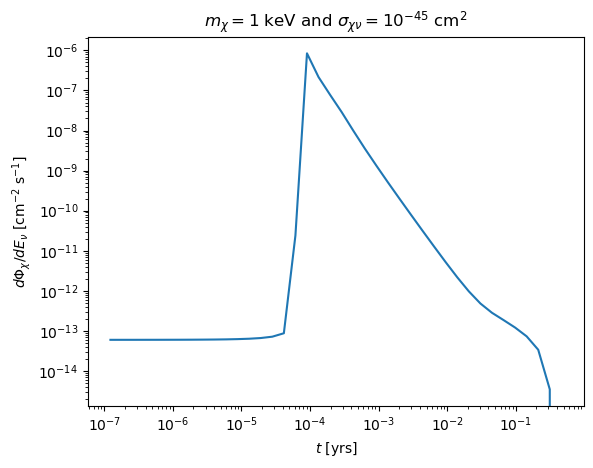

In [5]:
# Evaluate SNv BDM flux from various position
Tx,mx=15,1e-3
Rstar=8.5
beta=0
tp,tvan=snorer.get_tof(Tx,mx,Rstar)
tList = np.logspace(np.log10(tp/500),np.log10(tvan),40)

# # multiprocessing, default is sigxv = 1e-45 cm^2
pool = mp.Pool(8)
BDMflux = pool.map(partial(snorer.flux,Tx=Tx,mx=mx,Rstar=Rstar,beta=beta,neval=10000),tList)

#save data for later use
np.savetxt('BDMflux_mx_1keV_sigxv_1e-45_spike.txt', np.vstack((tList,BDMflux)).T,fmt='%.5e     %.5e', header='t [s]      flux [1/MeV/cm^2/s]')
#load previously saved data
BDMflux = np.loadtxt('BDMflux_mx_1keV_sigxv_1e-45_spike.txt').T

#　Make the plot
#plt.plot(tList/snorer.constant.year2Seconds,BDMflux)
plt.plot(BDMflux[0]/snorer.constant.year2Seconds,BDMflux[1])  # plot from loaded data
plt.xscale('log')
plt.yscale('log')
plt.title(r'$m_\chi = 1$ keV and $\sigma_{\chi\nu}=10^{-45}$ cm$^2$')
plt.xlabel(r'$t$ [yrs]')
plt.ylabel(r'$d\Phi_\chi/dE_\nu$ [cm$^{-2}$ s$^{-1}$]')
plt.show()

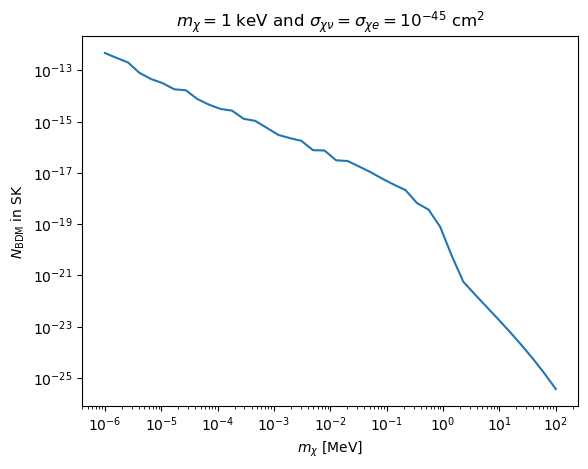

In [6]:
# Evaluate SNv BDM event from various position
Rstar=8.5
beta=0
mxList = np.logspace(-6,2,40)

# # multiprocessing, default is sigxv = 1e-45 cm^2
pool = mp.Pool(8)
BDMevent = pool.map(partial(snorer.event,Rstar=Rstar,beta=beta,is_spike=False,neval=30000),mxList)

Ne = 7e33                                # SK total electron number
sigxe = 1e-45                            # DM-e cross section
BDMevent = np.array(BDMevent)*Ne*sigxe   # Total event in SK
# save data for later use
np.savetxt('BDMevent_SK_mx_1keV_sigxv_1e-45_sigxe_1e-45_nospike.txt', np.vstack((mxList,BDMevent)).T,fmt='%.5e     %.5e', header='mx [MeV]         event [#]')
# load previously saved data
BDMevent = np.loadtxt('BDMevent_SK_mx_1keV_sigxv_1e-45_sigxe_1e-45_nospike.txt').T

# make the plot
#plt.plot(mxList,BDMevent)
plt.plot(BDMevent[0],BDMevent[1])
plt.xscale('log')
plt.yscale('log')
plt.title(r'$m_\chi = 1$ keV and $\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-45}$ cm$^2$')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$N_{\rm BDM}$ in SK')
plt.show()

## 6 The Astrophysical Relations

#### $M-\sigma$ relation

The stellar velocity dispersion $\sigma_star$ in the galactic bulge under the influence of SMBH with mass $M_{\rm BH}$
$$
\log_{10}\left(\frac{M_{\rm BH}}{M_\odot}\right) = 8.29+5.12 \log_{10} \left( \frac{\sigma_\star}{200~{\rm km~s^{-1}}}\right)
$$
See *Nature* **480**, 215 (2011).

#### SMBH Influence Radius

The SMBH influence radius $r_h$ is defined by
$$
r_h = \frac{G M_{\rm BH}}{\sigma_\star^2}
$$

####  Schwarzschild Radius

The Schwarzschild radius $R_S$ of a BH is defined by
$$
R_S = \frac{2G M_{\rm BH}}{c^2}
$$

### 6.a The Useful Functions

#### snorer.M_sigma
`snorer.M_sigma(mBH)` Obtain $\sigma_\star$ for BH mass $M_{\rm BH}$

##### Parameters:

   - **mBH** : The BH mass in $M_\odot$, float

##### Returns:

   - $\sigma_\star$ : stellar velocity dispersion in km/s, float

#### snorer.radiusInfluence

`snorer.radiusInfluence(mBH)` Obtain $r_h$ for BH mass $M_{\rm BH}$

##### Parameters:
   
   - **mBH** : The BH mass in $M_\odot$, float

##### Returns:

   - $r_h$ :  The influence radius in kpc, float

#### snorer.radiusSchwarzschild

`snorer.radiusSchwarzschild(mBH)` Obtain $R_S$ for BH mass $M_{\rm BH}$

##### Parameters:
   
   - **mBH** : The BH mass in $M_\odot$, float

##### Returns:

   - $R_S$ :  The Schwarzschild radius in kpc, float

## 7 *Experimental* :: Implementation of Particle Physics Model to SN$\nu$ BDM in Arbitrary Distant Galaxy

In `snorer`, we also offer an *experimental* but *powerful* feature, that users can implement their own particle model to see how SN$\nu$ BDM signature reacts to such model.
Additionally, this interface also accepts SN in arbitrary distant galaxy once its coordinate and the coordinate of the associated galaxy are provided.

This task will be accomplished by the class `GeneralInterface`. We illustrate this class and its usage step-by-step with an vivid $L_{\mu}-L_\tau$ plus $U(1)_D$ model to gauge the DM and $\nu,e$ interactions. The detailed Lagrangian and Feynman diagrams are documented in *Phys. Rev. D* **108**, 083013 (2023), we do not reproduce them here.

### 7.a The Classes

#### snorer.GeneralInterface


*class*  `snorer.GeneralInterface(SN_coord,GC_coord,amp2_xv,amp2_xe,/,**kwargs)` 

Class with medoths that evaluate SNv BDM coming from SN in arbitrary distant galaxy with DM-$\nu$ and DM-$e$ interaction cross sections descrbied by a specified particle physics model.
This class has an dependency on `Astropy` for handling SN/GC coordinates expressed in **ICRS J2000.0** system.

##### Parameters:

 - **SN_coord** : SN coordinate and distance, list
 - **GC_coord** : GC coordinate and distance, list
 - **amp2_xv** : Amplitude square for DM-$\nu$ scattering, func type
 - **amp2_xe** : Amplitude square for DM-$e$ scattering, func type
 - **\*\*kwargs** : Keyword arguments that will be passed to dmNumberDensity(), see the
              following explanation

##### - The coordinate inputs -

The first two inputs are a list with three elements, **[RA,DEC,dist]**, where **RA** and **DEC** are the right ascension and declination, respectively, of the celestial object expressed in ICRS J2000.0 system. Both are string type. The **dist** is the distance to the object in kpc and is float type.

We have documented coordinates  for three celestial objects, namely Sagittarius A*, SN1987a and LMC, given by `snorer.constant.SgrA_coord`, `snorer.constant.SN1987a_coord` and `snorer.constant.LMC_coord`. Users can check these three for the legal expression for these two inputs. Coordinates of other stellar objects can be obtained from NASA/IPAC database.

##### - The amplitude-squared inputs -

To practically understand how SN$\nu$ BDM signature reacts to the particle physics model, it is crucial to provide the scattering amplitude-squared for DM-$\nu$ and DM-$e$ interactions.
We do not require users to provide them in differential cross section forms, we only ask users to prepare the scattering amplitude-squared $|\mathcal{M}|^2$ in terms of Mandelstam variables and DM mass $m_\chi$ as a functional type.

For instance, the $|\mathcal{M}|^2$  that described  $L_{\mu}-L_\tau$ plus $U(1)_D$  has a general expression 
$$
|\mathcal{M}|^{2} =2\left(\frac{\mathcal{Q}}{t-m_{V}^{2}}\right)^{2}[s^{2}+u^{2}
   +4t(m_{1}^{2}+m_{2}^{2}) -2(m_{1}^{2}+m_{2}^{2})^{2}]
$$
where $m_1$ is the mass of the incident particle and $m_2$ the mass of the target. $\mathcal{Q}$ is a factor related to coupling constants on each vertex and $m_V$ the mediator mass.

To construct the legal functional inputs **amp2_xv** and **amp2_xe**, they can only have **FOUR** *positional-only* arguments **(s,t,u,mx,/)**. The first three are the Mandelstam variables and the last is the DM mass.
Thus, a proper way to construct them are

In [7]:
def amp2_xv(s,t,u,mx,/) -> float:
    """Amplitude-squared for DM-v scattering"""
    mV = mx
    gV,gx = 1e-05,1e-02
    Q = gV*gx
    return 2*(s**2 + u**2 + 4*t*mx**2 - 2*mx**4)*(Q/(t - mV**2))**2

def amp2_xe(s,t,u,mx,/) -> float:
    """Amplitude-squared for DM-e scattering"""
    mV = mx/3
    me = snorer.constant.me
    gx,eps = 1e-02,1e-06
    Q = gx*eps
    return 2*(s**2 + u**2 + 4*t*(me**2 + mx**2) - 2*(me**2 + mx**2)**2)*(Q/(t - mV**2))**2

In the above, one sees that users should express $m_V$ either a constant or $m_\chi$-dependent and $\mathcal{Q}$ is already a multiplication of coupling constants.

##### - The keyword arguments -

The variable-length argument list, **\*\*kwargs**, will be passed to `snorer.dmNumberDensity()` for constructing users' own DM halo model.
If nothing is specified, then `snorer.GeneralInterface` will setup MW profile without spike feature by default when an instance is established.

If users would like to change certain feature, they can simply add, eg., `is_spike=True`, `sigv=3`.
Since `dmNumberDensity()` also allows user to specify `(rhos,rs,n,mBH,rh}`, users can also add them into **\*\*kwargs** on-demand.

##### - Initializing a GeneralInterface instance -

Now we start the example by initializing an instance with amplitude-squareds are given above. We will use SN1987a in LMC as our celestial targets with some specified **kwargs.

In [8]:
# Initializing a GeneralInterface instance
SN_coord = snorer.constant.SN1987a_coord
GC_coord = snorer.constant.LMC_coord
bdmSN1987a = snorer.GeneralInterface(SN_coord,GC_coord,amp2_xv,amp2_xe,is_spike=True)

Note that the user-specified **kwargs are stored as a python `dict` object and can be viewed by

In [9]:
# update **kwargs sigv
bdmSN1987a.__dict__

{'SN_coord': ['05h35m27.8733s', '-69d16m10.478s', 51.4],
 'GC_coord': ['05h23m34.5264s', '-69d45m22.053s', 49.97],
 'amp2_xv': <function __main__.amp2_xv(s, t, u, mx, /) -> float>,
 'amp2_xe': <function __main__.amp2_xe(s, t, u, mx, /) -> float>,
 'is_spike': True}

We forgot to include the argument `profile='LMC'` since the default value is `'MW'` in `dmNumberDensity()`. Let's add it by

In [10]:
bdmSN1987a.profile = 'LMC'
# view the profile setup
bdmSN1987a.__dict__

{'SN_coord': ['05h35m27.8733s', '-69d16m10.478s', 51.4],
 'GC_coord': ['05h23m34.5264s', '-69d45m22.053s', 49.97],
 'amp2_xv': <function __main__.amp2_xv(s, t, u, mx, /) -> float>,
 'amp2_xe': <function __main__.amp2_xe(s, t, u, mx, /) -> float>,
 'is_spike': True,
 'profile': 'LMC'}

The `profile` is now contained in *kwargs* dict. Furthermore, there are four attributes already assigned at the inception

In [11]:
bdmSN1987a

       Dist to GC: 4.997e+01 kpc
       Dist to SN: 5.140e+01 kpc
  Seperation dist: 1.754e+00 kpc
 Off-center angle: 2.004e-02 rad

and they can be simply retrieved by

**- Attributes -**

 - *attribute* **Re** : Distance to GC in kpc, float
 - *attribute* **Rstar** : Distance to SN in kpc, float
 - *attribute* **separation_3d** : Separation distance between the two objects in kpc, float
 - *attribute* **beta** : Off-center angle $\beta$ in rad, float

One will see that due to SN1987a's location does not coincide with LMC center, eventually the results for `is_spike=True` and `False` will not be different so much.

Now we move to the useful methods that are inherited in the instance.

**- Methods -**

*method* `disgma_xv(Tx,mx,psi)` Obtain the differential DM-$\nu$ cross section, $d\sigma_{\chi\nu}/d\Omega|_\psi$, at $\psi$

##### Parameters:

 - **Tx** : BDM kinetic energy in MeV, float
 - **mx** : DM mass in MeV, float
 - **psi** : Lab frame scattering angle in rad, float

##### Returns:

 - $d\sigma_{\chi\nu}/d\Omega|_\psi$ : The differential cross section in ${\rm cm^2}~{\rm sr^{-1}}$, float

*method* `sigma_xe(Tx,mx)` Obtain the total DM-$e$ cross section, $\sigma_{\chi e}$

##### Parameters:

 - **Tx** : BDM kinetic energy in MeV, float
 - **mx** : DM mass in MeV, float

##### Returns:

 - $\sigma_{\chi e}$ : The total cross section in cm<sup>2</sup>, float

*method* `flux(t,Tx,mx,tau=10,nitn=10,neval=30000)` Obtain the BDM flux $d\Phi_{\chi}/dT_\chi$

##### Parameters:

 - **t** : BDM arrival time in seconds, float
 - **Tx** : BDM kinetic energy in MeV, float
 - **mx** : DM mass in MeV, float
 - **tau** : Duration of SN explosion in seconds, float
 - **nitn** : Numer of chains in for iterations, vegas variable, unsigned int
 - **neval** : Number of evaluations in each chain, vegas variable, unsigned int
        

##### Returns:

 - $d\Phi_{\chi}/dT_\chi$ : The SN$\nu$ BDM flux in ${\rm MeV^{-1}~cm^{-2}~s^{-1}}$, float

*method* `event(mx,TxRange=[5,30],tRange=[10,35*constant.year2Seconds],tau=10,nitn=10,neval=30000)` Obtain the BDM event $N_{\rm BDM}$ normalized to total electron number $N_e=1$

##### Parameters:

 - **mx** : DM mass in MeV, float
 - **TxRange** : BDM kinetic energy range of interest $[T_{\chi,{\rm min}},T_{\chi,{\rm max}}]$ in MeV, list
 - **tRange** : Detector exposure time $[t_{\rm min},t_{\rm max}]$ in seconds, list <br>
     Note that in principle the integration will terminate at $t_{\rm van}$ if $t_{\rm van}<t_{\rm max}$ </br>
 - **tau** : Duration of SN explosion in seconds, float
 - **nitn** : Numer of chains in for iterations, vegas variable, unsigned int
 - **neval** : Number of evaluations in each chain, vegas variable, unsigned int
        

##### Returns:

 - $N_{\rm BDM}$ : float

### 7.b Examples

#### The scattering cross sections
Let's the differential DM-$\nu$ cross section. Because `disgma_xv(Tx,mx,psi)` yields $d\sigma_{\chi\nu}/d\Omega$, we can covert it into $d\sigma_{\chi\nu}/d\psi$ by
$$
\frac{d\sigma_{\chi\nu}}{d\Omega}=\frac{1}{2\pi}\frac{d\sigma_{\chi\nu}}{d\cos\psi}  \to \frac{d\sigma_{\chi\nu}}{d\psi} = 2\pi \sin\psi \frac{d\sigma_{\chi\nu}}{d\Omega}
$$
where the valid $\psi$ is within
$$
0\leq \psi < \cos^{-1}\left(\frac{T_\chi}{p_\chi}\right).
$$
A build-in function `snorer.get_maxPsi(Tx,mx)` can be use to retrieve this. Note that the return value $\cos^{-1}(T_\chi/p_\chi)$ is actually invalid, so one should set the maximum $\psi_{\rm max}$ slightly smaller than this one if warning message occurs. We let the users decide.

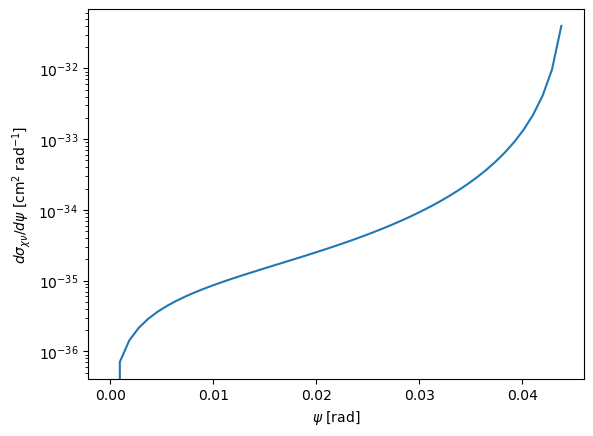

In [20]:
# DM-nu differential cross section
Tx,mx=10,0.01
maxPsi = snorer.get_maxPsi(Tx,mx) # maximum allowed scattering angle psi
psiList = np.linspace(0,maxPsi,50) # a slight displacement of the maxPsi
dsigmaxvList = [bdmSN1987a.dsigma_xv(10,0.01,psi)*np.sin(psi)*2*np.pi for psi in psiList]

# make the plot, similar to Fig. 14 in Phys. Rev. D 108, 083013 (2023)
plt.plot(psiList,dsigmaxvList)
plt.xlabel(r'$\psi$ [rad]')
plt.ylabel(r'$d\sigma_{\chi\nu}/d\psi$ [cm$^2$ rad$^{-1}$]')
plt.yscale('log')

The total DM-*e* cross section $\sigma_{\chi e}$ can be derived from
$$
\sigma_{\chi e} = 2\pi\int_{t_-}^{t_+} dt\frac{d\sigma_{\chi e}}{dt}
$$
where
$$
\frac{d\sigma_{\chi e}}{dt}=\frac{|\mathcal{M}|^2}{64\pi s |\mathbf{p}|^2}
$$
and
$$
|\mathbf{p}|^2=\frac{1}{4s}[s-(m_f+m_\chi)^2][s-(m_f-m_\chi)^2]
$$
is the CM frame momentum squared.
Thus $\sigma_{\chi e}$ only concerns the incident BDM kinetic energy $T_\chi$. We actually use `scipy.integrate.quad()` to peform the integration over $t$ and $t_\pm$ is obtained from `snorer.get_tBound()`. The streamline process is done automatically without users' intervention.

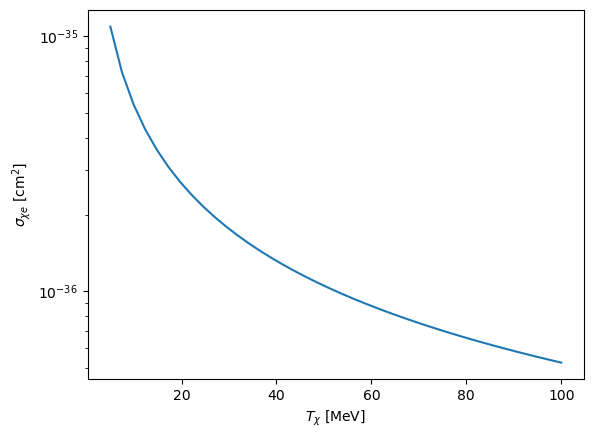

In [21]:
TxList = np.linspace(5,100,40)
sigmaxeList = [bdmSN1987a.sigma_xe(Tx,0.01) for Tx in TxList]

# make the plot
plt.plot(TxList,sigmaxeList)
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$\sigma_{\chi e}$ [cm$^2$]')
plt.yscale('log')

#### The associated SN$\nu$ BDM flux

Let's evaluate the BDM flux associated with this instance here.

In [11]:
# Evaluate SNv BDM flux from various position
Rstar = bdmSN1987a.Rstar
tp,tvan=snorer.get_tof(Tx,mx,Rstar)
tList = np.logspace(np.log10(tp/500),np.log10(2*tvan),40)

# multiprocessing, default is sigxv = 1e-45 cm^2
pool = mp.Pool(8)
BDMflux_SN1987a = pool.map(partial(bdmSN1987a.flux,Tx=Tx,mx=mx,neval=15000),tList)

#save data
np.savetxt('Flux_LMC_gV_1e-6_gx_1e-2_nospike.txt',np.vstack((tList,BDMflux_SN1987a)).T,fmt='%.5e    %.5e',header='gV=1e-6, gx=1e-2, mV=mx/3\nt [s]   flux [1/MeV/cm^2/s]')

# load data
bdmflux_SN1987a = np.loadtxt('Flux_LMC_gV_1e-6_gx_1e-2_nospike.txt').T 

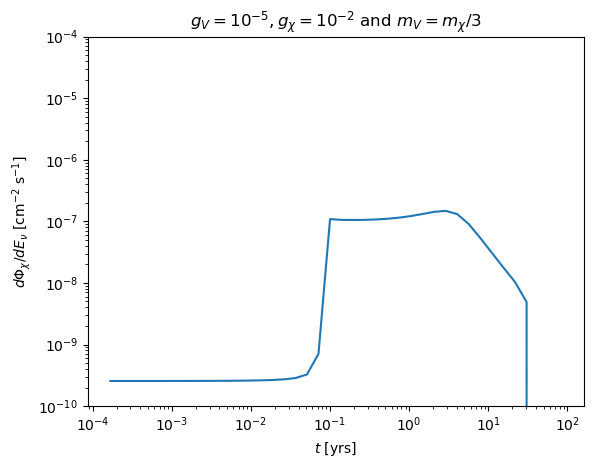

In [14]:
#　Make the plot
plt.plot(bdmflux_SN1987a[0]/snorer.constant.year2Seconds,bdmflux_SN1987a[1])  
plt.xscale('log')
plt.yscale('log')
plt.title(r'$g_V=10^{-5},g_\chi=10^{-2}$ and $m_V=m_\chi/3$')
plt.xlabel(r'$t$ [yrs]')
plt.ylabel(r'$d\Phi_\chi/dE_\nu$ [cm$^{-2}$ s$^{-1}$]')
plt.ylim(1e-10,1e-4)
plt.show()

One can see the spike at the peak is completely smeared deu to the existence of DM annihilation. Non-zero $\langle \sigma v\rangle$ will remove a significant portion of the spiky halo in the inner region. It makes the shape much cored than the original NFW profile.